# Opal Masterclass mit Maschine Learning

### 1. Vorbereitung

In diesem Block werden verschiedene Funktionen und Pakete geladen. Das musst du dir nicht weiter anschauen.

In [1]:
import os, platform
if "opal_mc_ml_helpers.py" in os.listdir():
    print("Helpers schon vorhanden")
else:
    if platform.system() == "Linux":
        print("Helpers nicht vorhanden, starte Download...", end="")
        os.system("wget -O opal_mc_ml_helpers.py \"https://raw.githubusercontent.com/ntiltmann/opal-mc-ml/main/opal_mc_ml_helpers.py\"")
        print(" abgeschlossen!")
    elif platform.system() == "Darwin":
        print("Helpers nicht vorhanden, starte Download...", end="")
        os.system("curl -o opal_mc_ml_helpers.py \"https://raw.githubusercontent.com/ntiltmann/opal-mc-ml/main/opal_mc_ml_helpers.py\"")
        print(" abgeschlossen!")
    else:
        raise Exception("Kein Automatischer Download unter Windows möglich. Bitte alle Dateien manuell herunterladen und entpacken.")
from opal_mc_ml_helpers import *
check_files()

Helpers schon vorhanden


2023-10-26 11:39:47.690596: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 11:39:47.942235: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 11:39:47.943346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 11:39:52.133133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Images were found
Category list was found


Die Funktion `load_events()` lädt alle Ereignisse und gibt sie als Liste aus. In der nächsten Zeile werden also alle Events in eine Liste mit dem Namen `eventliste` geladen.

In [2]:
eventliste = load_events()

622  of  622  events loaded
 622 events loaded


Da Neuronale Netzwerke mit mehr Trainingsdaten besser funktionieren, wurden aus diesen Ereignissen durch Kombination neue Ereignisse generiert, die für das Training des Neuronalen Netzwerks verwendet werden können.
Die Funktion `load_training_events()` lädt alle dieser Ereignisse und gibt sie wieder als eine Liste aus. In der nächsten Zeile werden also alle diese Ereignisse in eine Liste mit dem Namen `trainingsliste` geladen.

In [3]:
trainingsliste = load_training_events()

8697  of  8697  events loaded
 8697 trainig-events loaded


Mit `eventliste[x]` kann auf das `x+1`-ste Ereignis zugegriffen werden. Die Methode `.show_image()` gibt das Ereignis grafisch aus. Dieser Schritt hat keine Auswirkungen auf das Neuronale Netz o.ä sondern dient nur der Visualisierung. 

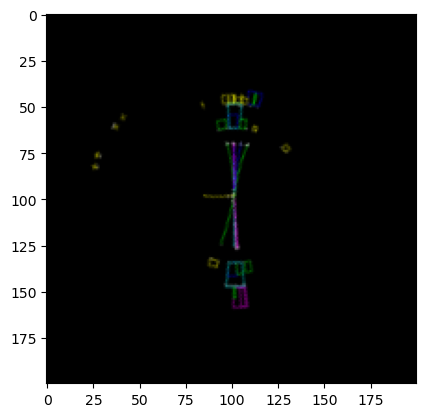

Name: z5301_1008.png 	 Category: q


In [4]:
eventliste[540].show_image(show_category=True)

### 2. Übersichtstabelle anlegen

Es wird ein Objekt der Klasse `Overview` erstellt. Damit können später Übersichten der Verzweigungsverhältnisse angezeigt werden.

Mit `overview.add_entry()` kann eine bestimmte Eventliste der Übersicht hinzugefügt werden. Der erste Parameter gibt an, wie die Spalte beschriftet sein soll. Danach folgt die Eventliste selbst.

Mit `overview.show()` kann dann die Übersicht angezeigt werden.

In [119]:
overview = Overview()
overview.add_entry("Roh", eventliste)
overview.show()

	Roh			Theory			
#Evt:	622			

q:	539	86.66%		87.38%
e:	23	3.70%		4.20%
m:	32	5.14%		4.21%
t:	28	4.50%		4.21%


### 3. Training & Validierung

Als nächstes werden die Bilddateien in zwei Datensätze aufgeteilt. Einen für Training und Validierung (Abkürzung `tv`) und einen für den anschließenden Test des Neuronalen Netzes. Wähle an dieser Stelle das Verhältnis selber. Trage dafür eine Zahl zwischen `0`und `1` ein. Diese Zahl gibt an wie viel Prozent der Bilddateien in den Datensatz für Training und Validierung hinzugefügt werden. 

**Beispiel:** eventliste_tv, eventliste_test = split_events_random_in_category(eventliste, fraction_first_block=0.1) bedeutet, dass 10% jeder Eventkategorie der Bilddateien zufällig in den Datensatz für Training und Validierung (`eventliste_tv`) hinzugefügt werden und 90% für den anschließenden Test (`eventliste_test`) genutzt werden.

**Hinweis:** Bedenke, dass eine gute Datenbasis für Training und Validierung gebraucht wird, aber die für Training und Validierung verwendeten Daten bekannt sein müssen. Werden sehr viele Daten für Training und Validierung genutzt, bleiben nicht mehr ausreichend Daten für die eigentliche Datenauswertung mit dem Neuronalen Netz.   

In [120]:
eventliste_tv, eventliste_test = split_events_random_in_category(eventliste, fraction_first_block=0.4)

Die Übersicht wird aktualisiert und ausgegeben.

In [121]:
overview.add_entry("TV", eventliste_tv)
overview.add_entry("Test", eventliste_test)
overview.show()

	Roh			TV			Test			Theory			
#Evt:	622			247			375			

q:	539	86.66%		215	87.04%		324	86.40%		87.38%
e:	23	3.70%		9	3.64%		14	3.73%		4.20%
m:	32	5.14%		12	4.86%		20	5.33%		4.21%
t:	28	4.50%		11	4.45%		17	4.53%		4.21%


Im nächsten Schritt folgt die Data Augementation, das bedeutet, dass die `tv`-Daten mit Hilfe der `trainingsliste` vervielfältigt werden, damit das Training einfacher wird. Wähle zunächst für alle vier Faktoren (`faktor_q`, `faktor_e`, `faktor_m`, `faktor_t`) einen ganzzahligen Wert zwischen `1`und `5` mit dem die Daten vervielfältigt werden. Später kann es sinnvoll sein, diese Werte teilweise nochmal zu verändern. Grundsätzlich sind dann für `faktor_e`, `faktor_m`, `faktor_t` auch größere Werte als `5`. Das Maximum hängt von der Anzahl der Ereignisse in `eventliste_tv` ab und liegt bei `2n`, wobei n die Anzahl Ereignisse in der Kategorie ist.

In [122]:
faktor_q = 1         # Quarks
faktor_e = 18       # Elektronen
faktor_m = 24      # Myonen 
faktor_t = 22       # Tauonen
eventliste_tv_vermehrt = augment_events(eventliste_tv, trainingsliste, [faktor_q, faktor_e, faktor_m, faktor_t])

Nun werden die `tv`-Daten in Training (`t`) und Validierung (`v`) unterteilt.

In [123]:
eventliste_training, eventliste_validierung = split_events_random_in_category(eventliste_tv_vermehrt, fraction_first_block=0.8)

Die Übersicht wird aktualisiert und ausgegeben.

In [124]:
overview.add_entry("TV verm", eventliste_tv_vermehrt)
overview.add_entry("Train", eventliste_training)
overview.add_entry("Vali", eventliste_validierung)
overview.show()

	Roh			TV			Test			TV verm			Train			Vali			Theory			
#Evt:	622			247			375			907			724			183			

q:	539	86.66%		215	87.04%		324	86.40%		215	23.70%		172	23.76%		43	23.50%		87.38%
e:	23	3.70%		9	3.64%		14	3.73%		162	17.86%		129	17.82%		33	18.03%		4.20%
m:	32	5.14%		12	4.86%		20	5.33%		288	31.75%		230	31.77%		58	31.69%		4.21%
t:	28	4.50%		11	4.45%		17	4.53%		242	26.68%		193	26.66%		49	26.78%		4.21%


### 4. Modell für das Neuronale Netz anlegen 

Die Trainingsdaten sind jetzt passend vorbereitet. Im nächsten Block wird ein Modell zum Lernen erstellt. Die Struktur wird einmal ausgegeben. In den letzten beiden Zeilen werden die Trainings- und Validierungsdaten geladen.

In [125]:
modell = MLModel()
modell.load_structure_default()
modell.show_structure()
modell.load_training_eventlist(eventliste_training)
modell.load_validation_eventlist(eventliste_validierung)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 66, 66, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 21, 21, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 19, 19, 64)        36928     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 6, 6, 64)         

### 5. Training des Modells

Mit `train()` wird das Training des Modells gestartet. `count_epochs` gibt an, wie oft über alle Trainings- und Validierungsdaten gelaufen wird. Bei diesen Daten sind häufig Werte zwischen 2 und 8 sinnvoll. Probiere aus, welche Unterschiede du beobachten kannst. 

**Achtung:** Um Unterschiede zwischen der Anzahl an Trainingsrunden beobachten zu können, muss auch die Zelle vorher, in der das Modell für das Neuronale Netz angelegt wurde, erneut ausgeführt werden.

In [127]:
modell.train(count_epochs=3)

Starting training...
Epoch 1/2
23/23 [==============================] - 6s 223ms/step - loss: 0.1965 - accuracy: 0.9337 - val_loss: 0.1416 - val_accuracy: 0.9563
Epoch 2/2
23/23 [==============================] - 5s 217ms/step - loss: 0.0773 - accuracy: 0.9820 - val_loss: 0.0431 - val_accuracy: 1.0000
Training finished, took 0:00:16.784637


Die Lernkurve zeigt an, wie die Treffergenauigkeit sich im Laufe des Trainings verändert. Dabei wird die Treffergenauigkeit in Trainingsdaten und Validierungsdaten getrennt aufgetragen.

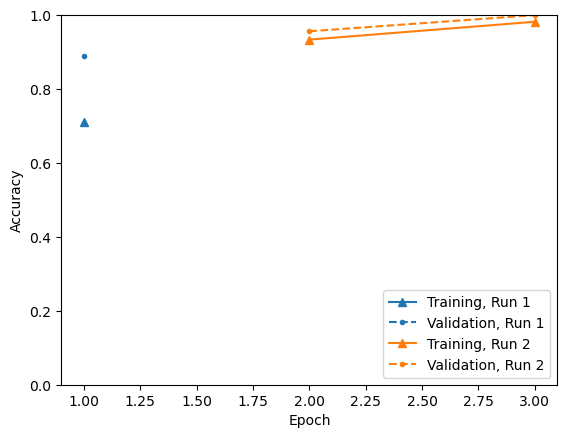

In [128]:
modell.show_learning_curve()

### 6. Vorhersage der OPAL-Daten mit dem Neuronalen Netz

Mit dem trainierten Modell können wir nun die Kategorien der Testdaten vorhersagen. Dabei wird die schon zugewiesene Kategorie der Testdaten ignoriert. 

In [129]:
eventliste_vorhersage = modell.predict(eventliste_test)

12/12 [==============================] - 1s 47ms/step


Die Confusion Matrix ist ein Indikator dafür, wie gut die Vorhersage mit dem Modell funktioniert. Ein perfektes Modell hätte nur Einträge auf der Diagonalen: Jede Kategorie wird vom Modell so erkannt, wie sie vorher schon dem Bild zugeordnet war. Tatsächlich treten häufig einige falsche Vorhersagen auf. 

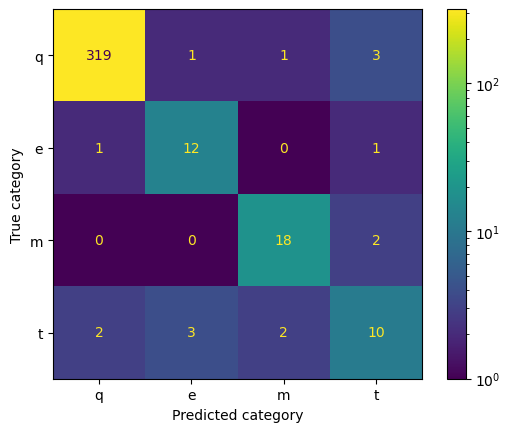

Total prediction accuracy: 0.9573


In [130]:
show_confusion_matrix(eventliste_test, eventliste_vorhersage)

Hier wird die Übersicht über die Verzweigungsverhältnisse noch um eine Spalte mit den vorhergesagten Daten erweitert.

In [131]:
overview.add_entry("Vorh", eventliste_vorhersage)
overview.show()

	Roh			TV			Test			TV verm			Train			Vali			Vorh			Theory			
#Evt:	622			247			375			907			724			183			375			

q:	539	86.66%		215	87.04%		324	86.40%		215	23.70%		172	23.76%		43	23.50%		322	85.87%		87.38%
e:	23	3.70%		9	3.64%		14	3.73%		162	17.86%		129	17.82%		33	18.03%		16	4.27%		4.20%
m:	32	5.14%		12	4.86%		20	5.33%		288	31.75%		230	31.77%		58	31.69%		21	5.60%		4.21%
t:	28	4.50%		11	4.45%		17	4.53%		242	26.68%		193	26.66%		49	26.78%		16	4.27%		4.21%


Man kann sich nun noch anschauen, welche Bilder falsch vorhergesagt wurden. Gelegentlich ist eine Einteilung auch für Menschen nicht eindeutig möglich.

Total of 16 wrong predictions
showing first 10 ...



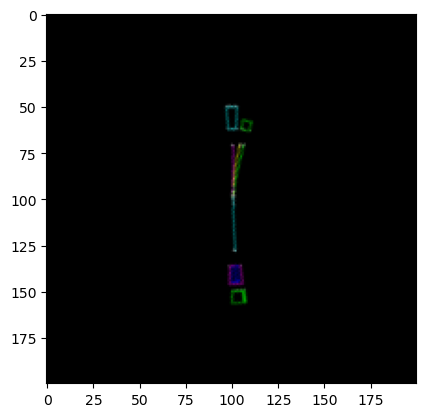

Name: z5293_8197.png
Probabilities for event being in class:
q	19.76%
e	77.11%
m	0.00%
t	3.13%
Was predicted as e but is q 



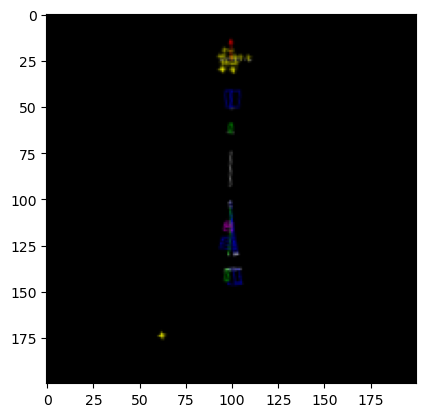

Name: z5297_4570.png
Probabilities for event being in class:
q	0.44%
e	35.86%
m	0.23%
t	63.46%
Was predicted as t but is q 



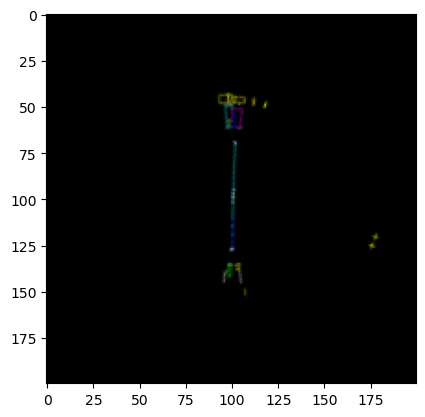

Name: z5297_6998.png
Probabilities for event being in class:
q	3.62%
e	1.35%
m	0.00%
t	95.03%
Was predicted as t but is q 



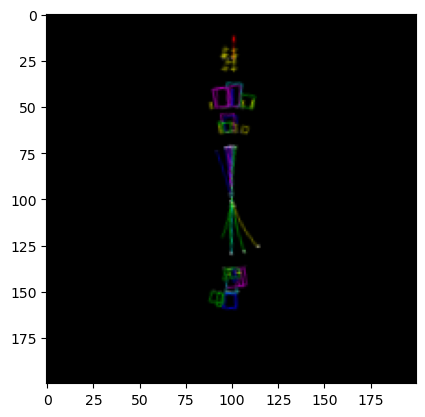

Name: z5299_4520.png
Probabilities for event being in class:
q	48.42%
e	0.70%
m	0.00%
t	50.89%
Was predicted as t but is q 



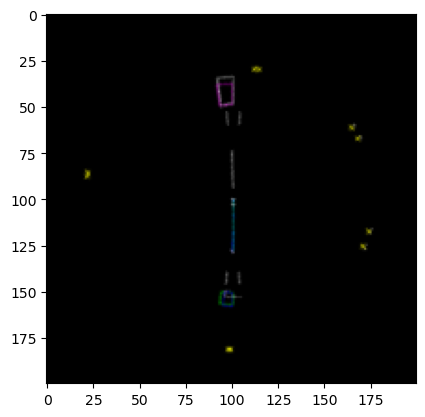

Name: z5293_941.png
Probabilities for event being in class:
q	0.00%
e	0.43%
m	71.17%
t	28.40%
Was predicted as m but is q 



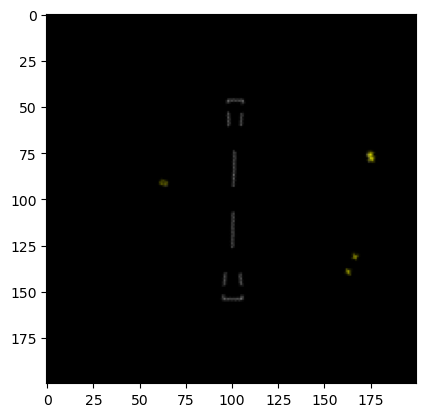

Name: e5293_14404.png
Probabilities for event being in class:
q	82.60%
e	15.60%
m	0.60%
t	1.19%
Was predicted as q but is e 



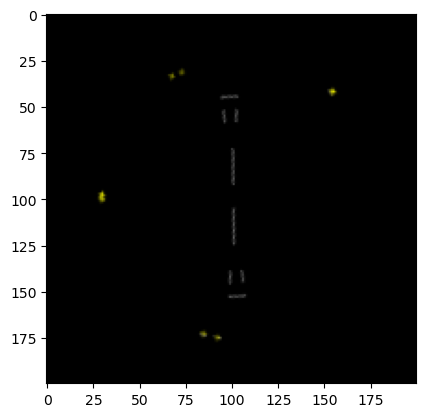

Name: e5293_18919.png
Probabilities for event being in class:
q	0.36%
e	0.77%
m	0.07%
t	98.80%
Was predicted as t but is e 



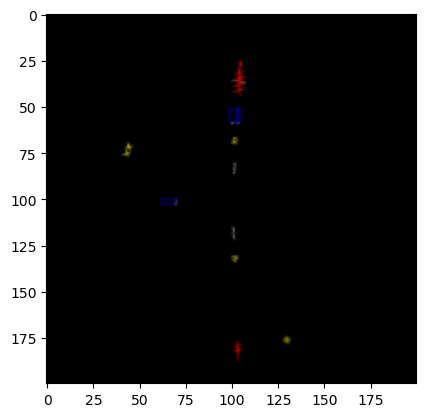

Name: z5293_18545.png
Probabilities for event being in class:
q	14.76%
e	0.73%
m	17.35%
t	67.15%
Was predicted as t but is m 



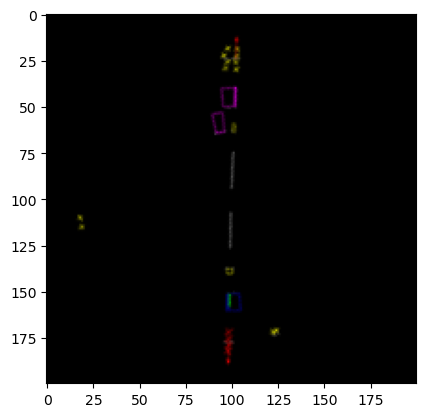

Name: z5293_14476.png
Probabilities for event being in class:
q	0.00%
e	0.03%
m	2.78%
t	97.19%
Was predicted as t but is m 



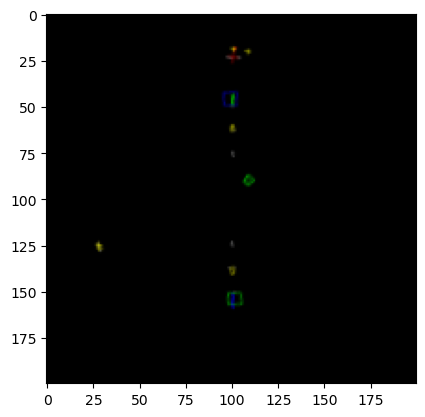

Name: z5293_6126.png
Probabilities for event being in class:
q	0.01%
e	0.00%
m	96.62%
t	3.37%
Was predicted as m but is t 



In [132]:
show_false_predictions(eventliste_test, eventliste_vorhersage, count=10)